In [37]:
import sys
#sys.path.append("/Users/Linus/Desktop/GIThubXAIFDEEPFAKE/Interpretable-Deep-Fake-Detection")
sys.path.append("/Users/toby/Interpretable-Deep-Fake-Detection")
#sys.path.append("Users/Toby/Interpretable-Deep-Fake-Detection/training")
sys.argv = ["train.py"]

In [38]:
from training.detectors import DETECTOR

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F
from train import init_seed, prepare_training_data, prepare_testing_data, choose_optimizer, choose_scheduler, choose_metric



## Load Xception Model

In [42]:

import yaml
from training.detectors import xception_detector
#i needed to append my analysis path to system to access the bcos saved models

def load_config(path, additional_args = {}):
    # parse options and load config
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    try:# KAI: added this, to ensure it finds the config file
        #with open('/Users/Linus/Desktop/GIThubXAIFDEEPFAKE/Interpretable-Deep-Fake-Detection/training/config/train_config.yaml', 'r') as f:
        with open('/Users/toby/Interpretable-Deep-Fake-Detection/training/config/train_config.yaml', 'r') as f:
            config2 = yaml.safe_load(f)
    except FileNotFoundError:
        #with open(os.path.expanduser('/Users/Linus/Desktop/GIThubXAIFDEEPFAKE/Interpretable-Deep-Fake-Detection/training/config/train_config.yaml'), 'r') as f:
        with open(os.path.expanduser('/Users/toby/Interpretable-Deep-Fake-Detection/training/config/train_config.yaml'), 'r') as f:
            config2 = yaml.safe_load(f)
    if 'label_dict' in config:
        config2['label_dict']=config['label_dict']
    config.update(config2)
    # config['local_rank']=args.local_rank
    if config['dry_run']:
        config['nEpochs'] = 0
        config['save_feat']=False
    for key, value in additional_args.items():
        config[key] = value
    return config

#path = "/Users/Linus/Desktop/GIThubXAIFDEEPFAKE/Interpretable-Deep-Fake-Detection/training/config/detector/xception.yaml"
path = "/Users/toby/Interpretable-Deep-Fake-Detection/training/config/detector/xception.yaml"
additional_args = {'test_batchSize': 12, 
                   'pretrained':
                    #f'/Users/Linus/Desktop/GIThubXAIFDEEPFAKE/Interpretable-Deep-Fake-Detection/weights/resnet/ckpt_best.pth'
                    f'/Users/toby/Interpretable-Deep-Fake-Detection/weights/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-10-17-17/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-12-19-31/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-17-23-41/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-21-26-03/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-21-43-33/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-08-09-13-00/test/avg/ckpt_best.pth'
                  }
config = load_config(path, additional_args=additional_args)
print("Registered models:", DETECTOR.data.keys())
model_class = DETECTOR[config['model_name']]
model = model_class(config)

model.eval()

Registered models: dict_keys(['vgg19_bcos', 'resnet34', 'resnet34_bcos', 'resnet34_bcos_v2', 'inception_bcos_detector', 'xception'])


XceptionDetector(
  (backbone): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

## Loading in a grid image

In [44]:
class MyToTensor(transforms.ToTensor):
    def __init__(self):
        """
        Same as transforms.ToTensor, except that if input to __call__ is already tensor, the input is returned unchanged
        """
        super().__init__()

    def __call__(self, input_img):
        if not isinstance(input_img, torch.Tensor):
            return super().__call__(input_img)
        return input_img
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if necessary
    MyToTensor(),            # Converts image to tensor if not already          
])


class CustomImageDataset(Dataset):
    def __init__(self, folder_paths, transform=None):
        """
        Args:
            folder_paths (dict): Dictionary where keys are folder paths, and values are the labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = []  # Store (image_path, label) tuples
        for fp, label in folder_paths.items():
            # List all subdirectories within the folder
            subfolders = [os.path.join(fp, d) for d in os.listdir(fp) if os.path.isdir(os.path.join(fp, d))]
        # Include images from the root directory as well as subfolders
        self.image_files.extend(
            [(os.path.join(fp, f), label) for f in os.listdir(fp) if f.endswith((".png", ".jpg"))]
        )

        for folder_path in subfolders:
            self.image_files.extend(
                [(os.path.join(folder_path, f), label) for f in os.listdir(folder_path) if f.endswith((".png", ".jpg"))]
            )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]  # Get image path and its label
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path


#file_path_deepfakebench = {"/Users/Linus/Desktop/GIThubXAIFDEEPFAKE/Interpretable-Deep-Fake-Detection/datasets/GPG_grids/3ch": 1}
file_path_deepfakebench = {"/Users/toby/Interpretable-Deep-Fake-Detection/datasets/2x2_images": 1}

dataset = CustomImageDataset(file_path_deepfakebench, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, label, img_path in dataloader:
    print(f"Batch of images shape: {images.shape}")
    break

Batch of images shape: torch.Size([20, 3, 224, 224])


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for img_batch, label_batch, path_batch in dataloader:
    print(f"Batch of images shape: {img_batch.shape}")

    # Iterate through the first 5 images in the batch
    num_images = min(len(img_batch), 20)
    for i in range(num_images):
        img = img_batch[i].unsqueeze(0).to(device)  # Process a single image
        label = label_batch[i]
        img_path = path_batch[i]
        img = img.requires_grad_(True)
        
        data_dict = {'image': img, 'label': label}
        
        model.zero_grad()
        out = model(data_dict)
        
        prob = out['prob']
        print('predicted prob', prob)


Batch of images shape: torch.Size([20, 3, 224, 224])


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


predicted prob tensor([0.5025], grad_fn=<SelectBackward0>)
predicted prob tensor([0.5025], grad_fn=<SelectBackward0>)
predicted prob tensor([0.5025], grad_fn=<SelectBackward0>)
predicted prob tensor([0.5025], grad_fn=<SelectBackward0>)
predicted prob tensor([0.5025], grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

## LIME

In [46]:
def batch_predict(images):
    """
    images: list or numpy array of images in HWC format (values 0-255)
    Returns: numpy array of prediction probabilities with shape [N, 2]
    """
    processed_images = []
    for img in images:
        # Convert numpy array (H, W, C) to PIL Image
        pil_img = Image.fromarray(img.astype(np.uint8))
        # Apply your custom transform
        tensor_img = transform(pil_img)  # This gives you a tensor of shape [C, 224, 224]
        processed_images.append(tensor_img.numpy())
    
    batch = np.stack(processed_images, axis=0)  # [N, C, 224, 224]
    batch = torch.from_numpy(batch).to(device)
    
    # Wrap in dict since your model expects {'image': tensor, ...}
    data = {'image': batch}
    with torch.no_grad():
        output = model(data)
        # Assuming binary classification: model returns a dict with key 'prob' (shape: [N])
        probs = output['prob'].cpu().numpy()
        # Convert to two-column probabilities if needed: [neg, pos]
        probs = np.vstack([1 - probs, probs]).T  # shape: [N, 2]
    return probs

In [47]:
def lime_grid_eval(heatmap, background_pixel = 0):  
    
    heatmap_gray =  np.mean(heatmap, axis=2)  # Average R, G, B channels
    if heatmap_gray.max() <= 1.0:  # If values are in range [0, 1]
        heatmap_gray = (heatmap_gray * 255).astype(np.uint8)
    
    # Check if the heatmap is square
    rows, cols = heatmap_gray.shape
    if rows != cols:
        raise ValueError("The heatmap must be square.")
    
    # Check divisibility by 2
    if rows % 2 != 0:
        raise ValueError("The heatmap dimensions must be divisible by 2.")
    
    # Split the heatmap into 4 sections
    half = rows // 2
    sections = [
        heatmap_gray[:half, :half],  # Top-left (0)
        heatmap_gray[:half, half:],  # Top-right (1)
        heatmap_gray[half:, :half],  # Bottom-left (2)
        heatmap_gray[half:, half:]   # Bottom-right (3)
    ]
    
    # Count white pixels in each section
    non_0_pixel_count = [np.sum(section > background_pixel) for section in sections]
    
    # Find the index of the section with the least white pixels
    fake_pred_index = np.argmax(non_0_pixel_count)
    
    return fake_pred_index, non_0_pixel_count #delete white pixel counts to remove from grid

Batch of images shape: torch.Size([20, 3, 224, 224])
torch.Size([1, 3, 224, 224])


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

1 [819, 7029, 3403, 1901]
1


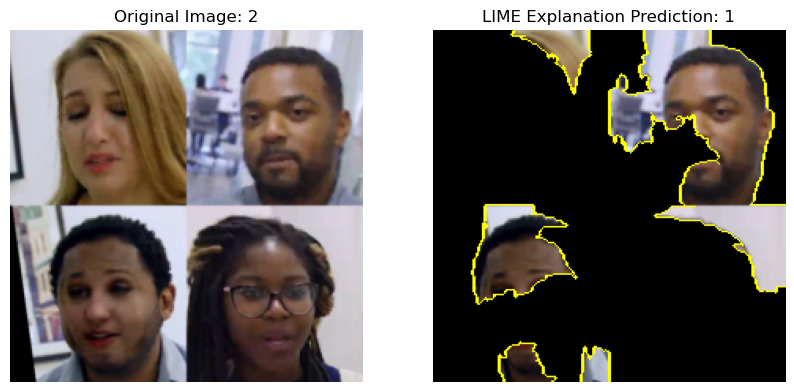

torch.Size([1, 3, 224, 224])


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

0 [5118, 2646, 543, 1872]
1


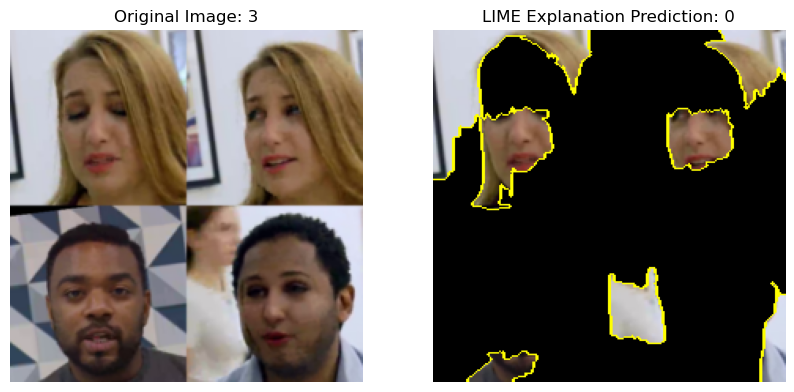

torch.Size([1, 3, 224, 224])


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

0 [0, 0, 0, 0]
1


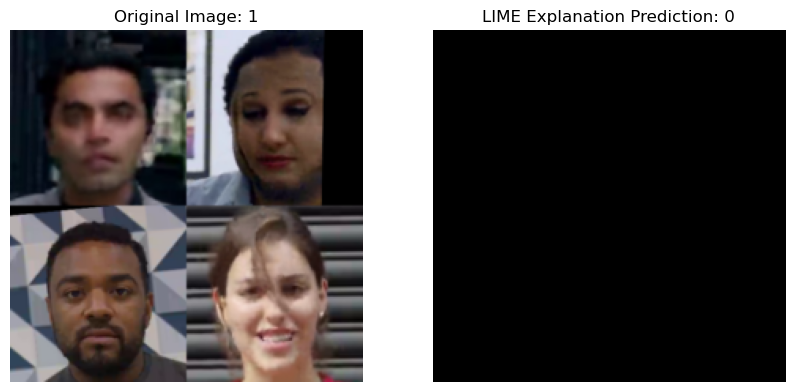

torch.Size([1, 3, 224, 224])


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

3 [1818, 410, 4244, 5941]
1


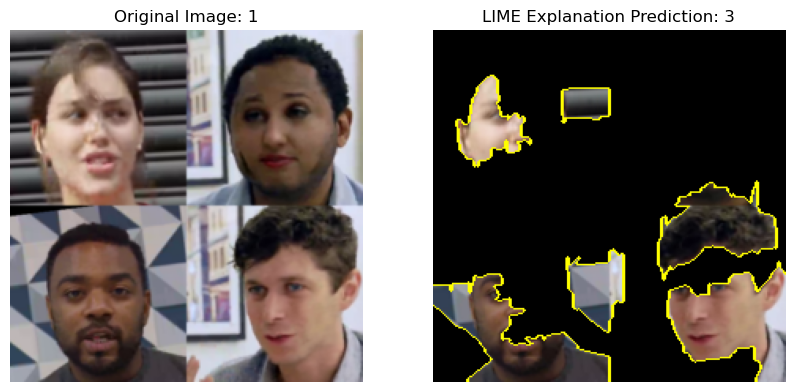

torch.Size([1, 3, 224, 224])


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

2 [204, 689, 7307, 3575]
1


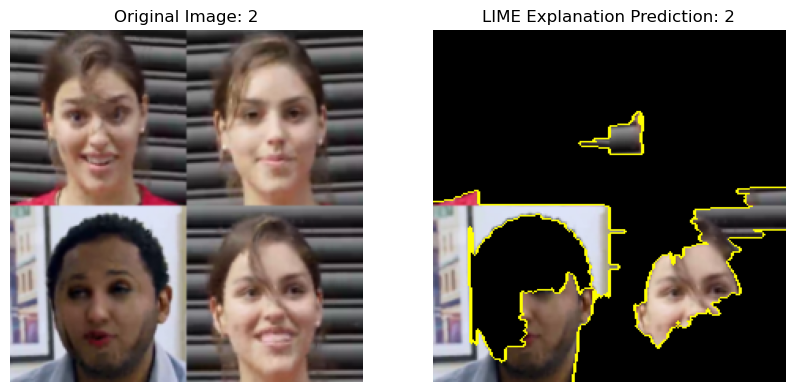

torch.Size([1, 3, 224, 224])


100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

0 [5821, 5409, 1584, 683]
1


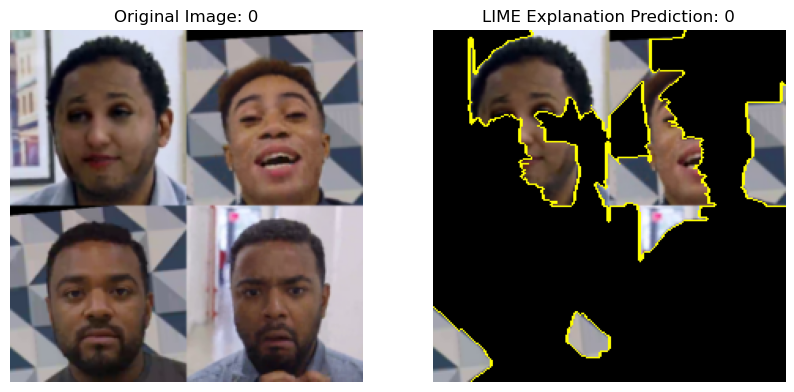

torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 

In [59]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

for img_batch, label_batch, path_batch in dataloader:
    print(f"Batch of images shape: {img_batch.shape}")

    # Iterate through the first 5 images in the batch
    num_images = min(len(img_batch), 20)
    for i in range(num_images):
        img = img_batch[i].unsqueeze(0).to(device)  # Process a single image
        label = label_batch[i]
        img_path = path_batch[i]
        print(img.shape)
        img_np = np.transpose(img[0,...].numpy(), (1, 2, 0))
        img = img.requires_grad_(True)

        
        data_dict = {'image': img, 'label': label}
        
        model.zero_grad()
        out = model(data_dict)
        
        explanation = explainer.explain_instance(
            img_np,
            batch_predict,
            top_labels = 1,
            hide_color = 0,
            num_samples = 10
        )
        
        top_label = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(
            top_label,
            positive_only=True,
            num_features=10,
            hide_rest=True
        )
        
        fake_pred, pixel_counts = lime_grid_eval(temp)
        print(fake_pred, pixel_counts)
        print(top_label)

        # Plot the original image with the LIME heatmap overlay
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        true_fake_pos = int(img_path.split('_fake_')[1].split('.')[0])

        # Original image
        ax[0].imshow(img_np)
        ax[0].axis('off')
        ax[0].set_title(f"Original Image: {true_fake_pos}")

        # Image with LIME explanation
        ax[1].imshow(mark_boundaries(temp, mask))
        ax[1].axis('off')
        ax[1].set_title(f'LIME Explanation Prediction: {fake_pred}')

        plt.show()  
        # Choose the label you want to inspect (often explanation.top_labels[0])
        label_to_inspect = explanation.top_labels[0]

        # # Retrieve the list of (superpixel_index, weight) for that label
        # superpixel_weights = explanation.local_exp[label_to_inspect]

        # # Print them
        # for sp_index, weight in superpixel_weights:
        #     print(f"Superpixel {sp_index} has weight {weight}")


